In [1]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

demo.launch()   

/Users/servandodavidtorresgarcia/miniconda3/envs/relu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [2]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(
    fn=greet,
    inputs=gr.Textbox(lines=2, placeholder="Name Here..."),
    outputs="text",
)
demo.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [3]:
import pandas as pd
predictions = pd.read_csv('../data/processed/predictions.csv')
optimal_prices = pd.read_csv('../data/processed/optimal_prices.csv')

In [8]:
predictions.tail(209)


,SKU,price,predicted_sales_xgboost
21450,SET436-KR-NP-XL,1399.00,1.195112
21451,SET436-KR-NP-XL,1259.10,1.195260
21452,SET436-KR-NP-XL,1189.15,1.195260
21453,SET436-KR-NP-XL,1538.90,1.157757
21454,SET436-KR-NP-XL,1608.85,1.123298
21455,SET436-KR-NP-XS,1399.00,1.195112
21456,SET436-KR-NP-XS,1259.10,1.195260
21457,SET436-KR-NP-XS,1189.15,1.195260
21458,SET436-KR-NP-XS,1538.90,1.157757
21459,SET436-KR-NP-XS,1608.85,1.123298


By selecting a single row from this table and substituting various values into the price column, you can obtain different sales values, which together form the predicted demand curve for a specific product

In [11]:
import matplotlib.pyplot as plt
# Plot the demand curve for this SKU
sku_results = predictions[predictions['SKU'] == sku]
plt.plot(sku_results['price'], sku_results['predicted_sales_xgboost'], label=sku)

    # Add labels and legend to the plot
plt.xlabel('Price')
plt.ylabel('Predicted Sales')
plt.legend()

    # Show the plot
plt.show()

NameError: name 'sku' is not defined

In [ ]:
import matplotlib.pyplot as plt

def perform_inference(train_data, test_data):
    # Fit the XGBoost model
    xgboost_model = XGBRegressor()
    xgboost_model.fit(train_data.drop(columns=['SKU', 'sales']), train_data['sales'])

    # Group test data by SKU
    grouped = test_data.groupby('SKU')

    # Create an empty dataframe to store the results
    results = pd.DataFrame(columns=['SKU', 'price', 'predicted_sales_xgboost'])

    # Perform inference for each SKU in test data
    for sku, group_data in grouped:
        print(f"Performing inference for SKU: {sku}")

        # Select one row from group data (one set of feature values for this SKU)
        feature_values = group_data.iloc[0]

        # Set the base price from data
        base_price = feature_values['price']

        # Define the price points
        price_points = [base_price, 
                        base_price * 0.9,   # base_price - 10%
                        base_price * 0.85,  # base_price - 15%
                        base_price * 1.1,   # base_price + 10%
                        base_price * 1.15]  # base_price + 15%

        # For each price point, use the trained model to predict sales and print the result
        for price in price_points:
            # Change the price while keeping other features constant
            test_features = feature_values.copy()
            test_features['price'] = price

            # Remove the SKU field to match the input shape expected by the model
            test_features = test_features.drop(['SKU', 'sales'])
 
            # Predict sales using the XGBoost model and append the results to the dataframe
            predicted_sales_xgboost = xgboost_model.predict(test_features.values.reshape(1, -1))[0]
            results = results.append({'SKU': sku, 'price': price, 'predicted_sales_xgboost': predicted_sales_xgboost}, ignore_index=True)

        # Plot the demand curve for this SKU
        sku_results = results[results['SKU'] == sku]
        plt.plot(sku_results['price'], sku_results['predicted_sales_xgboost'], label=sku)

    # Add labels and legend to the plot
    plt.xlabel('Price')
    plt.ylabel('Predicted Sales')
    plt.legend()

    # Show the plot
    plt.show()

    return results

In [16]:
import matplotlib.pyplot as plt

def plot_demand_curve(predictions, sku):
    # Select the predictions for the given SKU
    sku_predictions = predictions[predictions['SKU'] == sku]

    # Plot the predicted sales against the price points
    plt.plot(sku_predictions['price'], sku_predictions['predicted_sales_xgboost'], label=sku)

    # Add labels and legend to the plot
    plt.xlabel('Price')
    plt.ylabel('Predicted Sales')
    plt.legend()

    # Show the plot
    plt.show()

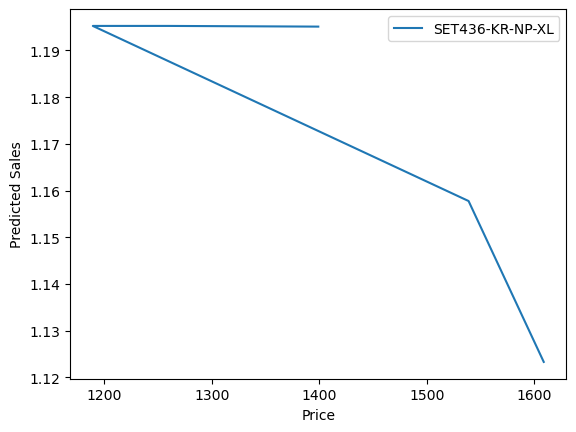

In [17]:
plot_demand_curve(predictions, 'SET436-KR-NP-XL')

In [28]:
import gradio as gr
import pandas as pd
import plotly.graph_objs as go


def plot_demand_curve(sku):
    # Load the predictions dataframe
    predictions = pd.read_csv('../data/processed/predictions.csv')

    # Select the predictions for the given SKU
    sku_predictions = predictions[predictions['SKU'] == sku]

    # Create a scatter plot of the predicted sales against the price points
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sku_predictions['price'], y=sku_predictions['predicted_sales_xgboost'], mode='lines+markers'))

    # Set the plot title and axis labels
    plot = fig.update_layout(title=f'Demand Curve for SKU {sku}', xaxis_title='Price', yaxis_title='Predicted Sales')

    # Return the plot as an HTML div
    return gr.update(value=plot, visible=True)

# Define the Gradio interface
#inputs = gr.inputs.Textbox(label='SKU')
inputs = gr.Textbox(lines=2, placeholder="Name Here...")
pip_plot = gr.Plot(visible=False)
interface = gr.Interface(fn=plot_demand_curve, inputs=inputs, outputs=pip_plot, examples=[['SET436-KR-NP-XL']])

# Run the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7870

To create a public link, set `share=True` in `launch()`.
